In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [11]:
# Save references to each table
station = Base.classes.station
measurement = Base.classes.measurement

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [10]:
# data types and columns for measurements
from sqlalchemy import inspect,func
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [16]:
# Find the most recent date in the data set.
recent_date = session.query(measurement.date).order_by(measurement.date.desc()).first()
recent_date

('2017-08-23',)

In [20]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
last_year_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)


# Perform a query to retrieve the data and precipitation scores
last_year_prcp = session.query(measurement.date, measurement.prcp).\
                        filter(measurement.date > last_year_date).\
                        order_by(measurement.date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
prcp_df = pd.DataFrame(last_year_prcp, columns=['Date', 'Precipitation'])


# Sort the dataframe by date
prcp_df.set_index('Date')
sorted_prcp = prcp_df.sort_values(by='Date')

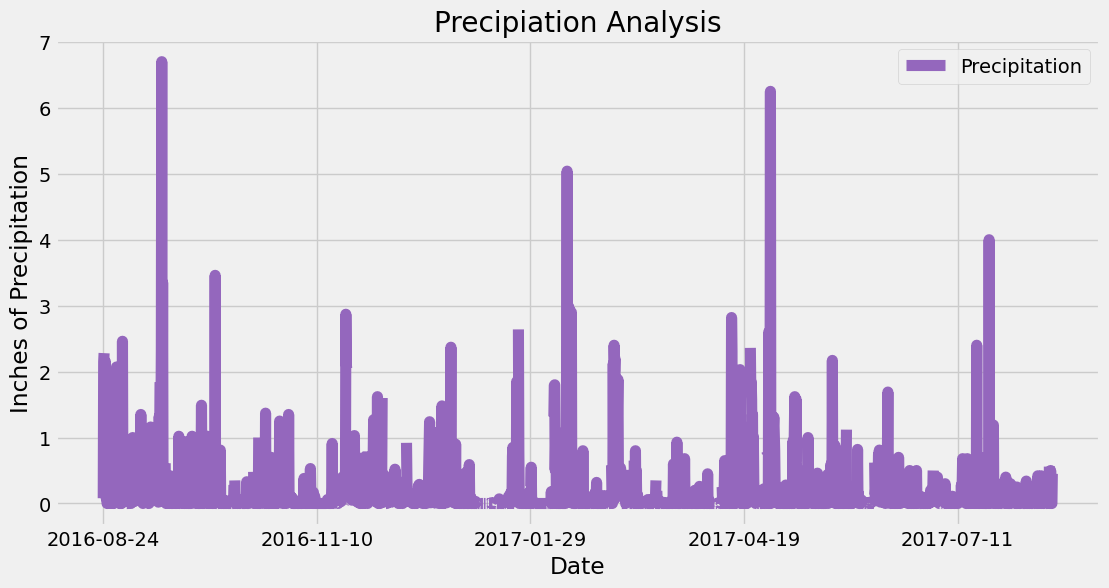

In [48]:
# Use Pandas Plotting with Matplotlib to plot the data
sorted_prcp.plot('Date', 'Precipitation', color='tab:purple', figsize=(12,6), 
                 linewidth=8)
plt.xlabel("Date")
plt.ylabel("Inches of Precipitation")
plt.title("Precipiation Analysis")

plt.savefig("images/precipitation.png")

plt.show()


In [22]:
# Use Pandas to calculate the summary statistics for the precipitation data
sorted_prcp.describe()

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [23]:
# data types and columns for station
inspector = inspect(engine)
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [27]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(station.id)).all()
total_stations


[(9,)]

In [29]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.

active_stations = session.query(measurement.station,func.count(measurement.station)).\
                       group_by(measurement.station).\
                       order_by(func.count(measurement.station).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [31]:
# Using the most active station id from the previous query, calculate the lowest, highest, average temperature.

most_active_temps = session.query(func.min(measurement.tobs), func.max(measurement.tobs), func.avg(measurement.tobs)).\
             filter(measurement.station==active_stations[0][0]).all()

most_active_temps

[(54.0, 85.0, 71.66378066378067)]

In [32]:
# Using the most active station id
most_active_station = active_stations[0][0]
most_active_station

'USC00519281'

In [37]:
# Query the last 12 months of temperature observation data for this station 
most_active_temps = session.query(measurement.tobs).\
             filter(measurement.station==active_stations[0][0]).\
             filter(measurement.date).all()

temps_df = pd.DataFrame(most_active_temps)
temps_df

,tobs
0,70.0
1,62.0
2,74.0
3,75.0
4,74.0
...,...
2767,77.0
2768,77.0
2769,76.0
2770,76.0


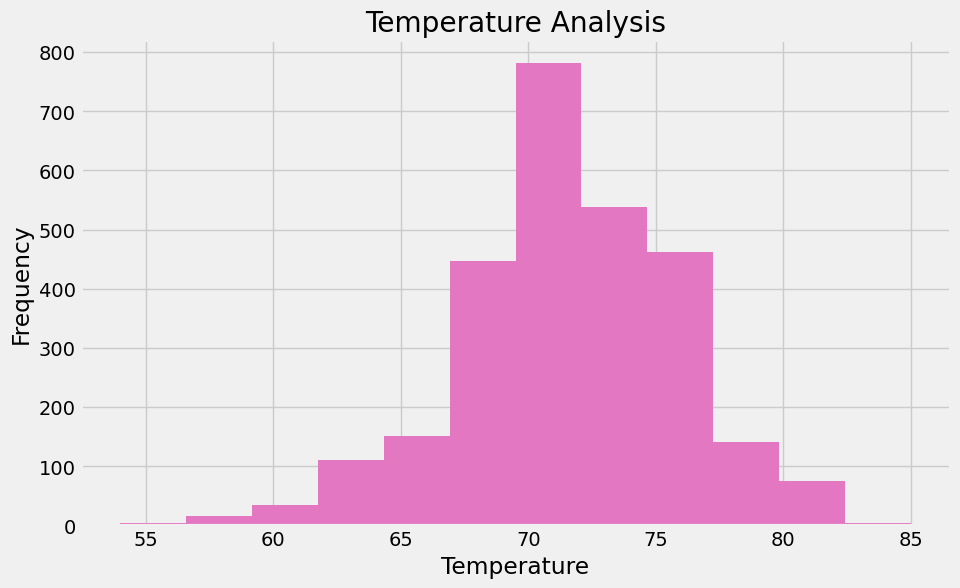

In [49]:
# plot the results as a histogram
temps_plot = temps_df['tobs'].hist(bins=12, figsize=(10,6), color='tab:pink')

plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.title("Temperature Analysis")

plt.savefig("images/temperature.png")
plt.show()

# Close Session

In [ ]:
# Close Session
session.close()